Notebook for exploring the latent structure of the data reported in Chen et al.  

In this notebook we look at latent structure within a single condition (e.g., phototaxis) but focus on differences in the latents within this condition (e.g., left vs right phototaxis). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import sklearn.decomposition as decomposition
from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.raw_data_processing import load_processed_data
from probabilistic_model_synthesis.fa import orthonormalize

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
ps = dict()
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'
ps['dataset'] = r'subject_11'
ps['n_components'] = 5

ps['condition'] = 'omr'
ps['shock'] = False



## Load the dataset

In [5]:
dataset = load_processed_data(Path(ps['data_dir']) / ps['dataset'], 11)

## Label all the time points in the dataset and find time points in the condition of interest

In [6]:
# Label all time points
subperiods = label_subperiods(dataset.ts_data['stim']['vls'][:])

# Downselect time points in the condition of interest
subperiods = {k:subperiods[k] for k in subperiods.keys() if ps['condition'] in k}

# Downselect time points with the shock condition we want
for key, subperiod_list in subperiods.items():
    subperiods[key] = [sp_i for sp_i in subperiod_list if sp_i['shock'] == ps['shock']]


## Pull out the data for each sub-condition (e.g., left vs right phototaxis)

In [7]:
all_data = dataset.ts_data['dff']['vls'][:]
subperiod_data = {key:np.concatenate(list(chain([all_data[sp_i['slice'],:] for sp_i in subperiods[key]])),
                                     axis=0) for key in subperiods.keys()} 

## Fit an FA model to the selected data

In [8]:
fit_data = np.concatenate([v for v in subperiod_data.values()], axis=0)

In [9]:
mdl = decomposition.FactorAnalysis(n_components=ps['n_components'])
mdl.fit(fit_data)

FactorAnalysis(n_components=5)

## Estimate latents for an orthonormalized model

In [10]:
latents = dict()
for key, cur_data in subperiod_data.items():
    cur_latents = mdl.transform(cur_data)
    o, cur_latents_o = orthonormalize(mdl.components_.transpose(), cur_latents)
    latents[key] = cur_latents_o    

## Visualize the latents

<IPython.core.display.Javascript object>


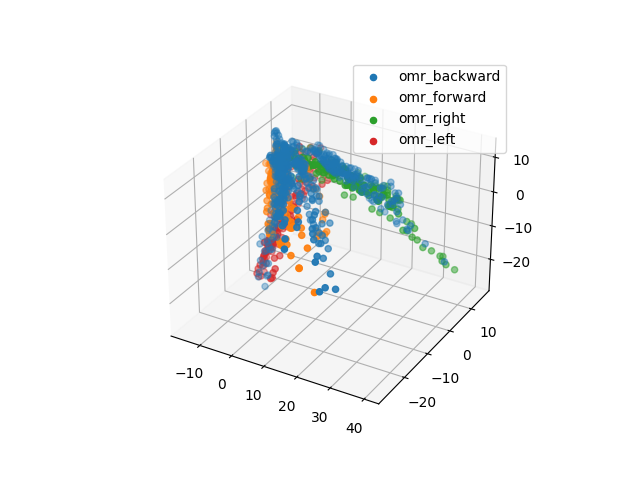

In [11]:
plt.figure()
ax = plt.axes(projection='3d')

for key, cur_latents in latents.items():
    ax.scatter(cur_latents[:,0], cur_latents[:,1], cur_latents[:,2])
    
plt.legend([k for k in latents.keys()])